In [3]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import lightning.pytorch as pl
from sklearn.model_selection import train_test_split
import numpy as np
import random


class MRIDataset(Dataset):
    def __init__(self, dataframe, slice_number, transform=None):
        self.df = dataframe.set_index(["ID", "slice_number"])
        self.slice_number = slice_number
        self.transform = transform
        self.resize = transforms.Resize(
            (224, 224)
        )  # Ensure images are resized to 224x224

    def __len__(self):
        return len(self.df.index.unique())

    def __getitem__(self, idx):
        id, slice_num = self.df.index.unique()[idx]
        images = []
        for offset in (-1, 0, 1):
            slice_path = self.get_random_path(id, slice_num + offset)
            image = Image.open(slice_path).convert("L")
            image = self.resize(image)  # Resize the image
            image = np.array(image)
            images.append(image)

        # Stack to create a 3-channel image
        image_stack = np.stack(images, axis=-1)  # Shape will be (H, W, C)
        image_stack = torch.tensor(image_stack).permute(
            2, 0, 1
        )  # Convert to (C, H, W) tensor

        # Normalize the image stack to [0, 1]
        image_stack = image_stack.float() / 255.0

        if self.transform:
            image_stack = self.transform(image_stack)

        return image_stack

    def get_random_path(self, id, slice_num):
        try:
            rows = self.df.loc[(id, slice_num)]
            if not rows.empty:
                # Randomly select between masked and unmasked if available
                row = rows.sample(n=1)
                return row["path"].values[0]
            else:
                # If the specific slice_num doesn't exist, default to the original slice
                return (
                    self.df.loc[(id, self.slice_number)].sample(n=1)["path"].values[0]
                )
        except KeyError:
            # In case the slice is completely unavailable, use the fallback slice
            return self.df.loc[(id, self.slice_number)].sample(n=1)["path"].values[0]


class MRIImageDataModule(pl.LightningDataModule):
    def __init__(self, data_path, batch_size=32, slice_number=87):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size
        self.slice_number = slice_number
        self.transform = transforms.Compose(
            [transforms.Normalize(mean=[0.5], std=[0.5])]
        )

    def setup(self, stage=None):
        data = pd.read_csv(self.data_path)
        train_ids, test_ids = train_test_split(
            data["ID"].unique(), test_size=0.2, random_state=42
        )

        train_df = data[data["ID"].isin(train_ids)]
        test_df = data[data["ID"].isin(test_ids)]

        self.train_dataset = MRIDataset(
            train_df, self.slice_number, transform=self.transform
        )
        self.test_dataset = MRIDataset(
            test_df, self.slice_number, transform=self.transform
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)


# Usage
data_module = MRIImageDataModule(
    data_path="Data/metadata_for_preprocessed_files.csv", slice_number=63
)
data_module.setup()
train_loader = data_module.train_dataloader()
for batch in train_loader:
    # Each batch should have the dimensions [batch_size, channels, height, width]
    print(batch.shape)  # Should output torch.Size([batch_size, 3, 224, 224])
    break

torch.Size([32, 3, 224, 224])


/var/folders/l5/4bf7qdjd6k9b38g7jlnrcf580000gn/T/ipykernel_30646/2326577472.py:46: PerformanceWarning: indexing past lexsort depth may impact performance.
  rows = self.df.loc[(id, slice_num)]


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = {
    "ID": [
        "OAS1_0001_MR1",
        "OAS1_0001_MR1",
        "OAS1_0001_MR1",
        "OAS1_0002_MR1",
        "OAS1_0002_MR1",
        "OAS1_0003_MR1",
    ],
    "slice_number": [62, 63, 64, 63, 64, 63],
    "path": [
        "Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_slice_62.jpeg",
        "Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_slice_63.jpeg",
        "Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_slice_64.jpeg",
        "Data/OASIS_Extracted/OAS1_0002/OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc_slice_63.jpeg",
        "Data/OASIS_Extracted/OAS1_0002/OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc_slice_64.jpeg",
        "Data/OASIS_Extracted/OAS1_0003/OAS1_0003_MR1_mpr_n4_anon_111_t88_gfc_slice_63.jpeg",
    ],
    "CDR": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    "is_masked": [True, False, True, False, True, False],
}

df = pd.DataFrame(data)

train_ids, test_ids = train_test_split(
    df["ID"].unique(), test_size=0.2, random_state=42
)
train_df = df[df["ID"].isin(train_ids)]
test_df = df[df["ID"].isin(test_ids)]

train_size = len(train_df)
test_size = len(test_df)

train_ids, test_ids, train_size, test_size

(array(['OAS1_0002_MR1', 'OAS1_0003_MR1'], dtype=object),
 array(['OAS1_0001_MR1'], dtype=object),
 3,
 3)

In [2]:
train_df

,ID,slice_number,path,CDR,is_masked
3,OAS1_0002_MR1,63,Data/OASIS_Extracted/OAS1_0002/OAS1_0002_MR1_m...,0.0,False
4,OAS1_0002_MR1,64,Data/OASIS_Extracted/OAS1_0002/OAS1_0002_MR1_m...,0.0,True
5,OAS1_0003_MR1,63,Data/OASIS_Extracted/OAS1_0003/OAS1_0003_MR1_m...,0.0,False


In [3]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import lightning.pytorch as pl
from sklearn.model_selection import train_test_split
import numpy as np
import random


# class MRIDataset(Dataset):
#     def __init__(self, dataframe, slice_number, transform=None):
#         self.df = dataframe.set_index(['ID', 'slice_number'])
#         self.slice_number = slice_number
#         self.transform = transform
#         self.resize = transforms.Resize((224, 224))  # Ensure images are resized to 224x224 # TODO: better to have an assert to save time, since data should be this size already?

#     def __len__(self):
#         return len(self.df.index.unique())

#     def __getitem__(self, idx):
#         id, slice_num = self.df.index.unique()[idx]
#         images = []
#         for offset in (-1, 0, 1):
#             slice_path = self.get_random_path(id, slice_num + offset)
#             image = Image.open(slice_path).convert('L')
#             image = np.array(image)
#             images.append(image)

#         # Stack to create a 3-channel image
#         image_stack = np.stack(images, axis=-1)  # Shape will be (H, W, C)
#         image_stack = torch.tensor(image_stack).permute(2, 0, 1)  # Convert to (C, H, W) tensor

#         # Normalize the image stack to [0, 1]
#         image_stack = image_stack.float() / 255.0 # TODO: check if images were already normalized and resized to 224 by 224

#         if self.transform:
#             image_stack = self.transform(image_stack)

#         return image_stack

#     def get_random_path(self, id, slice_num):
#         try:
#             rows = self.df.loc[(id, slice_num)]
#             if not rows.empty:
#                 # Randomly select between masked and unmasked if available
#                 row = rows.sample(n=1)
#                 return row['path'].values[0]
#             else:
#                 # If the specific slice_num doesn't exist, default to the original slice
#                 return self.df.loc[(id, self.slice_number)].sample(n=1)['path'].values[0]
#         except KeyError:
#                print(f"KeyError: The slice number {slice_num} or id {id} does not exist in the Data.")
#         return None

# class MRIImageDataModule(pl.LightningDataModule):
#     def __init__(self, data_path, batch_size=32, slice_number=87):
#         super().__init__()
#         self.data_path = data_path
#         self.batch_size = batch_size
#         self.slice_number = slice_number

#     def setup(self, stage=None):
#         data = pd.read_csv(self.data_path)
#         train_ids, test_ids = train_test_split(data['ID'].unique(), test_size=0.2, random_state=42)

#         train_df = data[data['ID'].isin(train_ids)]
#         test_df = data[data['ID'].isin(test_ids)]

#         self.train_dataset = MRIDataset(train_df, self.slice_number)
#         self.test_dataset = MRIDataset(test_df, self.slice_number)

#     def train_dataloader(self):
#         return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

#     def val_dataloader(self):
#         return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)


# Usage
# data_module = MRIImageDataModule(data_path='Data/metadata_for_preprocessed_files.csv', slice_number=63)
# data_module.setup()
# train_loader = data_module.train_dataloader()
# for batch in train_loader:
#     # Each batch should have the dimensions [batch_size, channels, height, width]
#     print(batch.shape)  # Should output torch.Size([batch_size, 3, 224, 224])
#     break


import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split


class MRIDataset(Dataset):
    def __init__(self, dataframe, slice_number, transform=None):
        self.slice_number = slice_number
        self.transform = transform
        self.df = dataframe
        self.valid_ids = dataframe[dataframe["slice_number"] == slice_number][
            "ID"
        ].unique()
        self.df = self.df[self.df["ID"].isin(self.valid_ids)].set_index(
            ["ID", "slice_number"]
        )

    def __len__(self):
        return len(self.valid_ids)

    def __getitem__(self, idx):
        id = self.valid_ids[idx]
        images = []

        for offset in (-1, 0, 1):
            slice_path = self.get_random_path(id, self.slice_number + offset)
            image = Image.open(slice_path).convert("L")
            image = np.array(image)
            images.append(image)

        # Stack to create a 3-channel image
        image_stack = np.stack(images, axis=-1)  # Shape will be (H, W, C)
        image_stack = torch.tensor(image_stack).permute(
            2, 0, 1
        )  # Convert to (C, H, W) tensor

        # Normalize the image stack to [0, 1]
        image_stack = (
            image_stack.float() / 255.0
        )  # TODO: check if images are already normalized and sized to 224 224

        if self.transform:
            image_stack = self.transform(image_stack)

        return image_stack

    def get_random_path(self, id, slice_num):
        try:
            rows = self.df.loc[(id, slice_num)]
            if not rows.empty:
                # Randomly select between masked and unmasked if available
                row = rows.sample(n=1)
                return row["path"].values[0]
            else:
                # If the specific slice_num doesn't exist, default to the original slice
                return (
                    self.df.loc[(id, self.slice_number)].sample(n=1)["path"].values[0]
                )
        except KeyError:
            # In case the slice is completely unavailable, use the fallback slice
            try:
                return (
                    self.df.loc[(id, self.slice_number)].sample(n=1)["path"].values[0]
                )
            except KeyError:  #
                print(
                    f"KeyError: The slice number {self.slice_number} or id {id} does not exist in the Data."
                )
        return None


class MRIImageDataModule(pl.LightningDataModule):
    def __init__(self, data_path, batch_size=32, slice_number=87):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size
        self.slice_number = slice_number

    def setup(self, stage=None):
        data = pd.read_csv(self.data_path)

        # Filter to only include IDs with the specified slice_number
        data = data[
            data["slice_number"].isin(
                [self.slice_number - 1, self.slice_number, self.slice_number + 1]
            )
        ]

        train_ids, test_ids = train_test_split(
            data["ID"].unique(), test_size=0.2, random_state=42
        )

        train_df = data[data["ID"].isin(train_ids)]
        test_df = data[data["ID"].isin(test_ids)]

        self.train_dataset = MRIDataset(train_df, self.slice_number)
        self.test_dataset = MRIDataset(test_df, self.slice_number)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)


# Usage example
# data_module = MRIImageDataModule(data_path='Data/metadata_for_preprocessed_files.csv', slice_number=63)
# data_module.setup()
# train_loader = data_module.train_dataloader()
# for batch in train_loader:
#     print(batch.shape)  # Should output torch.Size([batch_size, 3, 224, 224])

/var/folders/l5/4bf7qdjd6k9b38g7jlnrcf580000gn/T/ipykernel_31166/2985792169.py:134: PerformanceWarning: indexing past lexsort depth may impact performance.
  rows = self.df.loc[(id, slice_num)]


                            Unnamed: 0 M/F Hand  Age  Educ  SES  MMSE  CDR  \
ID            slice_number                                                   
OAS1_0410_MR1 62                   372   F    R   23   NaN  NaN   NaN  0.0   
              62                   372   F    R   23   NaN  NaN   NaN  0.0   

                            eTIV  nWBV    ASF  Delay  \
ID            slice_number                             
OAS1_0410_MR1 62            1507  0.87  1.165    NaN   
              62            1507  0.87  1.165    NaN   

                                                                         path  \
ID            slice_number                                                      
OAS1_0410_MR1 62            Data/OASIS_Extracted/OAS1_0410/OAS1_0410_MR1_m...   
              62            Data/OASIS_Extracted/OAS1_0410/OAS1_0410_MR1_m...   

                            is_masked  
ID            slice_number             
OAS1_0410_MR1 62                False  
              62 

: 

In [1]:
from transformers import MobileViTImageProcessor
from PIL import Image
import torch

# Load the image processor
processor = MobileViTImageProcessor.from_pretrained("apple/mobilevit-xx-small")

# Load an image
image_path = "Data/Mean_Images/average_slice_0_masked_False.jpeg"
image = Image.open(image_path).convert("RGB")

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

print(inputs)

/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

{'pixel_values': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])}


In [6]:
print(inputs["pixel_values"].size())

torch.Size([1, 3, 256, 256])


In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import CIFAR10
import pytorch_lightning as pl
from transformers import MobileViTForImageClassification, MobileViTImageProcessor

# Custom dataset class to filter CIFAR-10 classes


class CIFAR10Subset(Dataset):
    def __init__(
        self, root, train=True, transform=None, download=False, class_subset=None
    ):
        self.dataset = CIFAR10(
            root=root, train=train, transform=transform, download=download
        )
        self.class_subset = class_subset
        if class_subset is not None:
            self.indices = [
                i
                for i, label in enumerate(self.dataset.targets)
                if label in class_subset
            ]
        else:
            self.indices = list(range(len(self.dataset)))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        image, label = self.dataset[index]
        label = self.class_subset.index(label)  # Reindex the label to [0, 1, 2, 3]
        return image, label


# Define the LightningModule


class MobileViTLightning(pl.LightningModule):
    def __init__(self, model_ckpt, num_labels):
        super(MobileViTLightning, self).__init__()
        self.model = MobileViTForImageClassification.from_pretrained(
            model_ckpt, num_labels=num_labels, ignore_mismatched_sizes=True
        )

    def forward(self, x):
        return self.model(x).logits

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=2e-5)


# Load the pretrained model and processor
model_ckpt = "apple/mobilevit-xx-small"
processor = MobileViTImageProcessor.from_pretrained(model_ckpt)

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

# Use only the first 4 classes for demonstration
class_subset = [0, 1, 2, 3]
train_dataset = CIFAR10Subset(
    root="./data",
    train=True,
    download=True,
    transform=transform,
    class_subset=class_subset,
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Initialize the model and trainer
model = MobileViTLightning(model_ckpt=model_ckpt, num_labels=4)
trainer = pl.Trainer(max_epochs=3)

# Train the model
trainer.fit(model, train_loader)

Files already downloaded and verified


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-xx-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 320]) in the checkpoint and torch.Size([4, 320]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML eco

Training: |          | 0/? [00:00<?, ?it/s]

/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
from torchvision import transforms
import pytorch_lightning as pl
from transformers import MobileViTForImageClassification, MobileViTImageProcessor

# Custom dataset class to filter CIFAR-10 classes and use MobileViTImageProcessor


class CIFAR10Subset(Dataset):
    def __init__(
        self, root, train=True, transform=None, download=False, class_subset=None
    ):
        self.dataset = CIFAR10(
            root=root, train=train, transform=None, download=download
        )
        self.transform = transform
        self.class_subset = class_subset
        if class_subset is not None:
            self.indices = [
                i
                for i, label in enumerate(self.dataset.targets)
                if label in class_subset
            ]
        else:
            self.indices = list(range(len(self.dataset)))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        label = self.class_subset.index(label)  # Reindex the label to [0, 1, 2, 3]
        return image, label


# Define the LightningModule


class MobileViTLightning(pl.LightningModule):
    def __init__(self, model_ckpt, num_labels):
        super(MobileViTLightning, self).__init__()
        self.model = MobileViTForImageClassification.from_pretrained(
            model_ckpt, num_labels=num_labels, ignore_mismatched_sizes=True
        )

    def forward(self, x):
        return self.model(x).logits

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=2e-5)


# Load the pretrained model and processor
model_ckpt = "apple/mobilevit-xx-small"
processor = MobileViTImageProcessor.from_pretrained(model_ckpt)

# Load and preprocess the CIFAR-10 dataset


def transform(image):
    # Use MobileViTImageProcessor for preprocessing
    return processor(image, return_tensors="pt")["pixel_values"].squeeze(0)


# Use only the first 4 classes for demonstration
class_subset = [0, 1, 2, 3]
train_dataset = CIFAR10Subset(
    root="./data",
    train=True,
    download=True,
    transform=transform,
    class_subset=class_subset,
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Initialize the model and trainer
model = MobileViTLightning(model_ckpt=model_ckpt, num_labels=4)
trainer = pl.Trainer(max_epochs=3)

# Train the model
trainer.fit(model, train_loader)

Files already downloaded and verified


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-xx-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 320]) in the checkpoint and torch.Size([4, 320]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                            | Params
----------------------------------------------------------
0 | model | MobileViTForImageClassification | 952 K 
----------------------------------------------------------
952 K     Trainable params
0         Non-trainable params
952 K     Total params
3.809    

Training: |          | 0/? [00:00<?, ?it/s]

In [7]:
for batch in train_loader:
    inputs, labels = batch
    print("Inputs shape:", inputs.shape)
    print("Labels:", labels)
    break  # Exit after the first batch

Inputs shape: torch.Size([4, 3, 256, 256])
Labels: tensor([1, 3, 1, 2])


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Create a mock dataset for testing
np.random.seed(42)
data = pd.DataFrame(
    {
        "ID": np.random.choice([f"ID{n}" for n in range(200)], size=10000),
        "CDR": np.random.choice(["Class1", "Class2", "Class3"], size=10000),
        "Feature": np.random.rand(10000),
    }
)

# Define the function for stratified group split


def stratified_group_split(
    data, group_col, stratify_col, test_size=0.125, random_state=42
):
    unique_ids = data[group_col].unique()
    stratify_values = data.groupby(group_col)[stratify_col].first().values
    train_val_ids, test_ids = train_test_split(
        unique_ids,
        test_size=test_size,
        stratify=stratify_values,
        random_state=random_state,
    )
    return train_val_ids, test_ids


# Perform initial stratified split
train_val_ids, test_ids = stratified_group_split(data, "ID", "CDR", test_size=0.125)

# Further stratified split train + validation
train_val_df = data[data["ID"].isin(train_val_ids)]
unique_train_val_ids = train_val_df["ID"].unique()
stratify_train_val_values = train_val_df.groupby("ID")["CDR"].first().values

train_ids, val_ids = train_test_split(
    unique_train_val_ids,
    test_size=0.142857,
    stratify=stratify_train_val_values,
    random_state=42,
)

# Create final DataFrames
train_df = data[data["ID"].isin(train_ids)]
val_df = data[data["ID"].isin(val_ids)]
test_df = data[data["ID"].isin(test_ids)]

# Function to check class distribution


def check_class_distribution(df, label_col):
    return df[label_col].value_counts(normalize=True)


# Function to check ID uniqueness across datasets


def check_id_uniqueness(train_ids, val_ids, test_ids):
    return len(set(train_ids) & set(val_ids) & set(test_ids)) == 0


# Test class distribution
train_class_dist = check_class_distribution(train_df, "CDR")
val_class_dist = check_class_distribution(val_df, "CDR")
test_class_dist = check_class_distribution(test_df, "CDR")

# Test ID uniqueness
id_uniqueness = check_id_uniqueness(train_ids, val_ids, test_ids)

# Print results
print("Train Class Distribution:\n", train_class_dist)
print("Validation Class Distribution:\n", val_class_dist)
print("Test Class Distribution:\n", test_class_dist)
print("ID Uniqueness Across Datasets:", id_uniqueness)

Train Class Distribution:
 CRD
Class1    0.342777
Class3    0.332754
Class2    0.324469
Name: proportion, dtype: float64
Validation Class Distribution:
 CRD
Class2    0.350919
Class3    0.331735
Class1    0.317346
Name: proportion, dtype: float64
Test Class Distribution:
 CRD
Class2    0.349921
Class1    0.327804
Class3    0.322275
Name: proportion, dtype: float64
ID Uniqueness Across Datasets: True


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from dataset import stratified_group_split


# Load the original data
data_path = "Data/metadata_for_preprocessed_files.csv"  # Update the path if needed
data = pd.read_csv(data_path)

# Filter to only include IDs with the specified slice_number
slice_number = 87
data = data[
    data["slice_number"].isin([slice_number - 1, slice_number, slice_number + 1])
]

# Initial stratified split: 87.5% train + validation, 12.5% test
train_val_ids, test_ids = stratified_group_split(data, "ID", "CDR", test_size=0.125)

# Creating the train + validation DataFrame for further splitting
train_val_df = data[data["ID"].isin(train_val_ids)]

# Further stratified split train + validation into 75% train and 12.5% validation (relative to the total dataset)
unique_train_val_ids = train_val_df["ID"].unique()
stratify_train_val_values = train_val_df.groupby("ID")["CDR"].first().values

train_ids, val_ids = train_test_split(
    unique_train_val_ids,
    test_size=0.142857,
    stratify=stratify_train_val_values,
    random_state=42,
)

# Creating the final DataFrames
train_df = data[data["ID"].isin(train_ids)]
val_df = data[data["ID"].isin(val_ids)]
test_df = data[data["ID"].isin(test_ids)]

# Function to display class distribution


def display_class_distribution(df, label_col):
    class_counts = df[label_col].value_counts(normalize=True) * 100
    print(class_counts)


# Display class distributions
print("Class Distribution in Training Set:")
display_class_distribution(train_df, "CDR")

print("\nClass Distribution in Validation Set:")
display_class_distribution(val_df, "CDR")

print("\nClass Distribution in Test Set:")
display_class_distribution(test_df, "CDR")

Class Distribution in Training Set:
CDR
0.0    77.300613
0.5    15.030675
1.0     7.055215
2.0     0.613497
Name: proportion, dtype: float64

Class Distribution in Validation Set:
CDR
0.0    78.181818
0.5    18.181818
1.0     3.636364
Name: proportion, dtype: float64

Class Distribution in Test Set:
CDR
0.0    74.545455
0.5    20.000000
1.0     5.454545
Name: proportion, dtype: float64


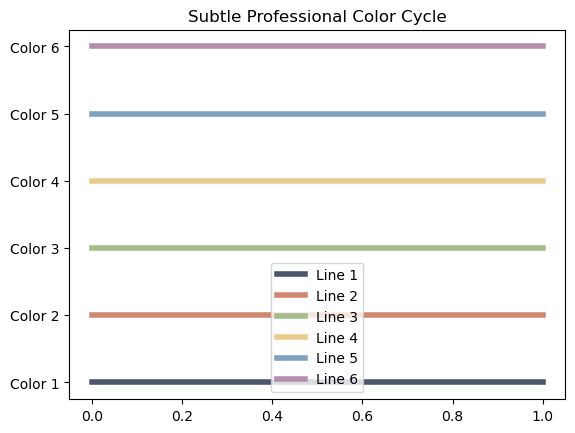

In [1]:
import matplotlib.pyplot as plt
from cycler import cycler

# Define a more subtle professional color cycle
subtle_colors = ["#4C566A", "#D08770", "#A3BE8C", "#EBCB8B", "#81A1C1", "#B48EAD"]

# Set the color cycle
plt.rc("axes", prop_cycle=(cycler("color", subtle_colors)))

# Displaying the color cycle for reference
fig, ax = plt.subplots()
for i, color in enumerate(subtle_colors):
    ax.plot([0, 1], [i, i], label=f"Line {i+1}", color=color, linewidth=4)
ax.set_yticks(range(len(subtle_colors)))
ax.set_yticklabels([f"Color {i+1}" for i in range(len(subtle_colors))])
ax.legend()
plt.title("Subtle Professional Color Cycle")
plt.show()

In [6]:
plt.cm.Paired(range(10))

array([[0.65098039, 0.80784314, 0.89019608, 1.        ],
       [0.12156863, 0.47058824, 0.70588235, 1.        ],
       [0.69803922, 0.8745098 , 0.54117647, 1.        ],
       [0.2       , 0.62745098, 0.17254902, 1.        ],
       [0.98431373, 0.60392157, 0.6       , 1.        ],
       [0.89019608, 0.10196078, 0.10980392, 1.        ],
       [0.99215686, 0.74901961, 0.43529412, 1.        ],
       [1.        , 0.49803922, 0.        , 1.        ],
       [0.79215686, 0.69803922, 0.83921569, 1.        ],
       [0.41568627, 0.23921569, 0.60392157, 1.        ]])

In [37]:
import pandas as pd
import numpy as np
# Read the CSV file into a DataFrame
df = pd.read_csv("MobileVit-s_test_features.csv") #efficientnet-b2_test_features.csv

# Display the first few rows of the DataFrame to understand its structure
print(df.head())

for col in df.columns:
    if col.startswith('slice_'):
        shapes = df[col].apply(lambda x: np.array(eval(x)).shape).unique()
        print(f"Unique shapes in column {col}: {shapes}")
        
df = pd.read_csv("efficientnet-b2_test_features.csv")

# Display the first few rows of the DataFrame to understand its structure

for col in df.columns:
    if col.startswith('slice_'):
        shapes = df[col].apply(lambda x: np.array(eval(x)).shape).unique()
        print(f"Unique shapes in column {col}: {shapes}")


              id  label                                           slice_65  \
0  OAS1_0015_MR1      1  [[[-0.25229278206825256, 0.13928011059761047, ...   
1  OAS1_0018_MR1      0  [[[-0.05814090371131897, 0.33775845170021057, ...   
2  OAS1_0030_MR1      0  [[[-0.1454559862613678, 0.23059681057929993, 0...   
3  OAS1_0032_MR1      0  [[[-0.22748146951198578, 0.1632922738790512, -...   
4  OAS1_0042_MR1      1  [[[-0.27394425868988037, -0.04483802244067192,...   

                                            slice_86  \
0  [[[-0.21840335428714752, -0.08603478968143463,...   
1  [[[0.008829454891383648, 0.4257102608680725, 0...   
2  [[[-0.1739734709262848, 0.10410880297422409, 0...   
3  [[[-0.20395860075950623, -0.19071735441684723,...   
4  [[[-0.21165381371974945, -0.16334886848926544,...   

                                            slice_56  \
0  [[[-0.08932934701442719, 0.08259967714548111, ...   
1  [[[-0.0836867094039917, 0.06479212641716003, 0...   
2  [[[-0.08837708085775375

In [29]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv("MobileVit-s_test_features.csv")  # Or "efficientnet-b2_test_features.csv"

# Get slice columns
slice_cols = [col for col in df.columns if col.startswith("slice_")]

# Example column
col = slice_cols[0]  # Choose the first slice column for example

# Apply the lambda function (don't modify the DataFrame)
data_as_array = df[col].apply(lambda x: np.array(eval(x)))

# Print the data type
print("Data type after conversion:", type(data_as_array[0]))
print(data_as_array[0].shape)


Data type after conversion: <class 'numpy.ndarray'>
(160, 8, 8)


In [41]:
import pandas as pd
import numpy as np
import pickle
import ast



# Read the CSV file
df = pd.read_csv("MobileVit-s_test_features.csv")  # Or "efficientnet-b2_test_features.csv"

# Get slice columns
slice_cols = [col for col in df.columns if col.startswith("slice_")]

# Function to apply global average pooling to a single feature map
def global_average_pooling(feature_map):
    feature_map_array = np.array(eval(feature_map))
    return np.mean(feature_map_array, axis=(1, 2))

# Apply global average pooling to all slice columns
for col in slice_cols:
    df[col] = df[col].apply(global_average_pooling)

# Save the resulting dataframe to a new CSV file
# Save the entire DataFrame to a pickle file
with open("pooled_features.pkl", 'wb') as f:
  pickle.dump(df, f)

print(df.head())

print("Global average pooling applied and saved to 'pooled_features.pkl'")


      
for col in df.columns:
    if col.startswith('slice_'):
        # Apply the lambda function to safely evaluate and get the shape of each entry in the column
        shapes = df[col].apply(lambda x: x.shape).unique()
        print(f"Unique shapes in column {col}: {shapes}")


              id  label                                           slice_65  \
0  OAS1_0015_MR1      1  [0.04813066132555832, -0.04713622734925593, 0....   
1  OAS1_0018_MR1      0  [0.3586162227438763, 0.21246038029130432, 0.59...   
2  OAS1_0030_MR1      0  [0.3882891414104961, 0.049010447968612425, 0.5...   
3  OAS1_0032_MR1      0  [-0.029309833640581928, -0.004151591070694849,...   
4  OAS1_0042_MR1      1  [0.06514524834528856, -0.029377146900515072, 0...   

                                            slice_86  \
0  [0.36068742984934943, -0.12050275613728445, 0....   
1  [1.0125237972679315, -0.09445420189513243, 0.2...   
2  [0.7383899635460693, -0.0965134708876576, 0.05...   
3  [0.25590031016326975, -0.1964317315578228, 0.0...   
4  [0.21610746272199322, -0.2421967783011496, -0....   

                                            slice_56  \
0  [0.11988802731502801, 0.292258673303877, 0.633...   
1  [0.46285671493524205, 0.12124050877173431, 0.4...   
2  [0.46527026532567106, 0

In [53]:
import pandas as pd
import numpy as np
import ast

# Load the DataFrame from the pickle file
with open("pooled_features.pkl", 'rb') as f:
  df = pickle.load(f)

for col in df.columns:
    if col.startswith('slice_'):
        # Apply the lambda function to safely evaluate and get the shape of each entry in the column
        shapes = df[col].apply(lambda x: x.shape).unique()
        print(f"Unique shapes in column {col}: {shapes}")
        
print(len(df))
        

feature_columns = sorted([col for col in df.columns if col.startswith('slice_')])
        
# Determine sequence length based on the number of feature columns
sequence_length = len(feature_columns)

row = df.iloc[0]
label = row['label']
print(f'label: {label}')
    
# Initialize sequence with zeros for missing slices
print(len(df[feature_columns[0]][0]))
print((feature_columns[0]))

Unique shapes in column slice_65: [(160,)]
Unique shapes in column slice_86: [(160,)]
Unique shapes in column slice_56: [(160,)]
Unique shapes in column slice_95: [(160,)]
Unique shapes in column slice_62: [(160,)]
Unique shapes in column slice_35: [(160,)]
Unique shapes in column slice_59: [(160,)]
Unique shapes in column slice_74: [(160,)]
Unique shapes in column slice_80: [(160,)]
Unique shapes in column slice_134: [(160,)]
55
label: 1
160
slice_134


In [4]:
import numpy as np
[np.random.rand(5) for _ in range(10)]

[array([0.14917306, 0.23044095, 0.33966759, 0.97329343, 0.97053232]),
 array([0.54637661, 0.28681746, 0.13016263, 0.11518522, 0.75032091]),
 array([0.35035602, 0.47268901, 0.21031133, 0.7499967 , 0.00438689]),
 array([0.62964998, 0.04877485, 0.17391147, 0.55106527, 0.23490187]),
 array([6.15904061e-01, 1.02852072e-04, 7.48742037e-01, 5.91255776e-01,
        1.86565666e-01]),
 array([0.24869062, 0.4002512 , 0.57921098, 0.26019694, 0.78118766]),
 array([0.67147652, 0.06165089, 0.22267552, 0.12664456, 0.70134487]),
 array([0.55441554, 0.63109345, 0.99037834, 0.28460451, 0.69377262]),
 array([0.45732933, 0.2039997 , 0.07265301, 0.30383941, 0.46041636]),
 array([0.79521841, 0.32261383, 0.82044727, 0.47185184, 0.04471406])]

In [6]:
from dataset import MRIFeatureDataset, MRIFeatureDataModule

dataset = MRIFeatureDataset('extracted_features/efficientnet-b2_test_features_pooled.pkl', as_sequence=True)
features, label = dataset[0]
features.shape


torch.Size([10, 1408])

In [8]:
dataset[0][0].shape

torch.Size([10, 1408])

/var/folders/l5/4bf7qdjd6k9b38g7jlnrcf580000gn/T/ipykernel_3146/3253184653.py:9: RuntimeWarning: divide by zero encountered in divide
  y_inverse_log = 1 / np.log(x)


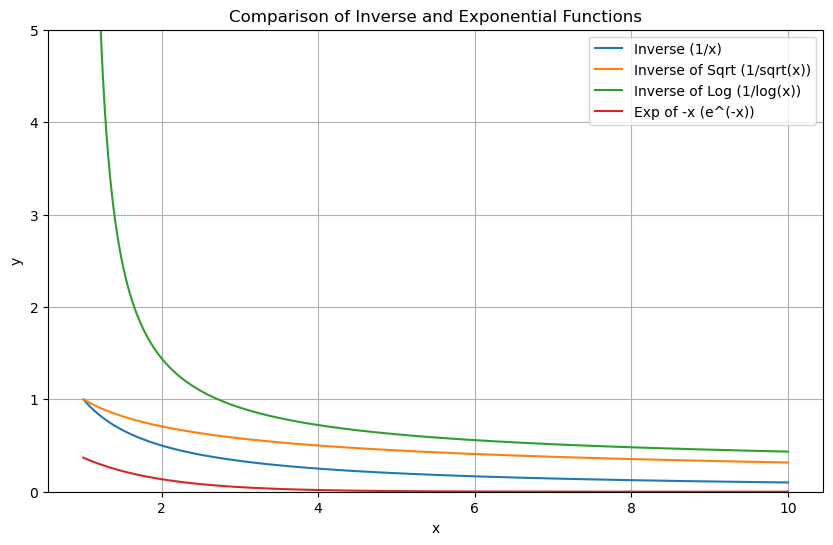

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# Generate x values
x = np.linspace(1, 10, 400)

# Compute y values for each function
y_inverse = 1 / x
y_inverse_sqrt = 1 / np.sqrt(x)
y_inverse_log = 1 / np.log(x)
y_exp_neg = np.exp(-x)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each function
plt.plot(x, y_inverse, label="Inverse (1/x)")
plt.plot(x, y_inverse_sqrt, label="Inverse of Sqrt (1/sqrt(x))")
plt.plot(x, y_inverse_log, label="Inverse of Log (1/log(x))")
plt.plot(x, y_exp_neg, label="Exp of -x (e^(-x))")

# Add titles and labels
plt.title("Comparison of Inverse and Exponential Functions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.ylim(0, 5)  # Limiting y-axis to 5

# Show the plot
plt.show()


/var/folders/l5/4bf7qdjd6k9b38g7jlnrcf580000gn/T/ipykernel_3146/2286752747.py:4: RuntimeWarning: divide by zero encountered in divide
  dy_inverse_log = -1 / (x * np.log(x)**2)


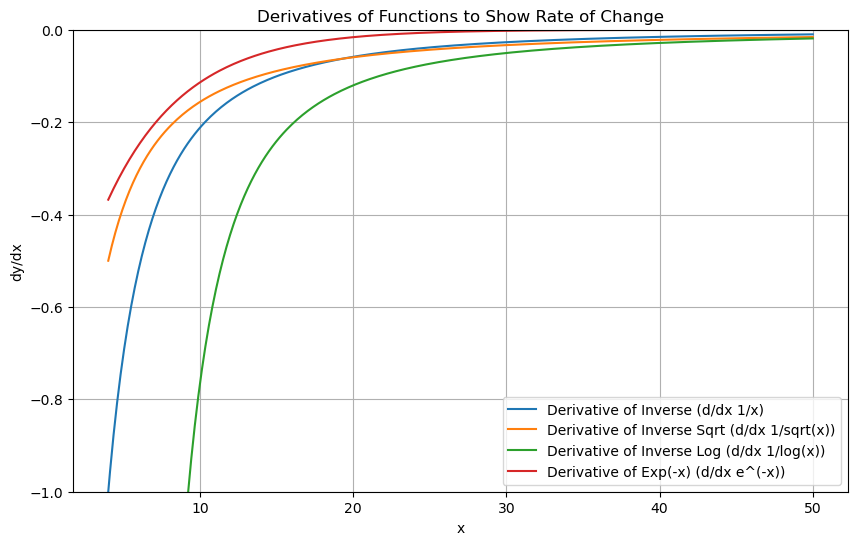

In [10]:
# Compute derivatives of each function
dy_inverse = -1 / x**2
dy_inverse_sqrt = -0.5 * x**(-1.5)
dy_inverse_log = -1 / (x * np.log(x)**2)
dy_exp_neg = -np.exp(-x)

x = np.linspace(4, 50, 400)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each derivative
plt.plot(x, dy_inverse, label="Derivative of Inverse (d/dx 1/x)")
plt.plot(x, dy_inverse_sqrt, label="Derivative of Inverse Sqrt (d/dx 1/sqrt(x))")
plt.plot(x, dy_inverse_log, label="Derivative of Inverse Log (d/dx 1/log(x))")
plt.plot(x, dy_exp_neg, label="Derivative of Exp(-x) (d/dx e^(-x))")

# Add titles and labels
plt.title("Derivatives of Functions to Show Rate of Change")
plt.xlabel("x")
plt.ylabel("dy/dx")
plt.legend()
plt.grid(True)
plt.ylim(-1, 0)  # Adjusting y-axis to better visualize the derivatives

# Show the plot
plt.show()


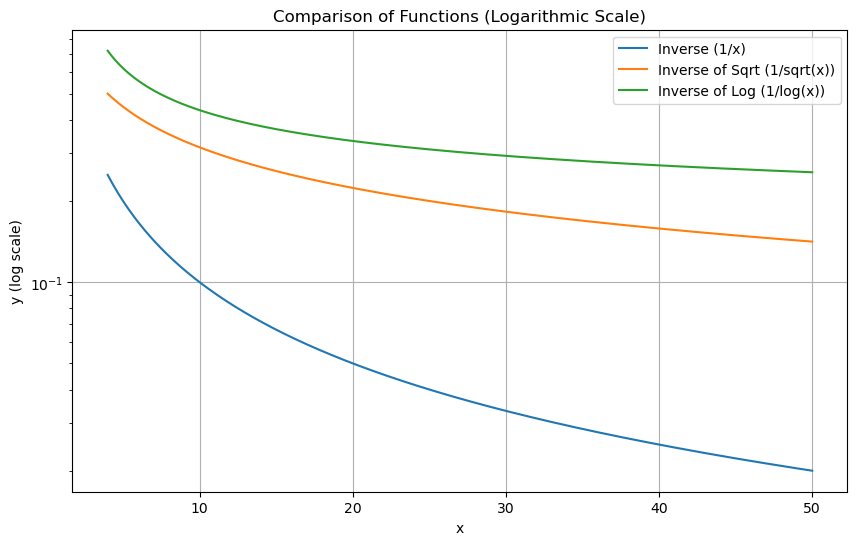

In [12]:

# Compute y values for each function within the smaller range
y_inverse_small = 1 / x
y_inverse_sqrt_small = 1 / np.sqrt(x)
y_inverse_log_small = 1 / np.log(x)
y_exp_neg_small = np.exp(-x)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each function with logarithmic y-axis
plt.plot(x, y_inverse_small, label="Inverse (1/x)")
plt.plot(x, y_inverse_sqrt_small, label="Inverse of Sqrt (1/sqrt(x))")
plt.plot(x, y_inverse_log_small, label="Inverse of Log (1/log(x))")
# plt.plot(x, y_exp_neg_small, label="Exp of -x (e^(-x))")

# Add titles and labels
plt.title("Comparison of Functions (Logarithmic Scale)")
plt.xlabel("x")
plt.ylabel("y (log scale)")
plt.yscale('log')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()